In [59]:
import numpy as np
import pandas as pd
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline 

In [2]:
seed = 7
np.random.seed(seed)

In [36]:
mypath = '/Users/Lucy/Google Drive/MSDS/2016Fall/DSGA1006/Data/lstm-rnn'
f = open(mypath + '/crunchbase.train.10000.pickle','rb')
train_x, train_y = pickle.load(f)
f.close()
f = open(mypath + '/crunchbase.test.10000.pickle','rb')
test_x, test_y = pickle.load(f)
f.close()

In [4]:
len(test_y)

12093

In [5]:
len(list(set(train_y)))

543

In [6]:
x_length = map(len, train_x)

In [7]:
print 'max description length is %s. min description length is %s' % (max(x_length), min(x_length))
print 'average description length is %s. median description length is %s' % (np.mean(x_length), np.median(x_length))

max description length is 1127. min description length is 0
average description length is 96.293508373. median description length is 78.0


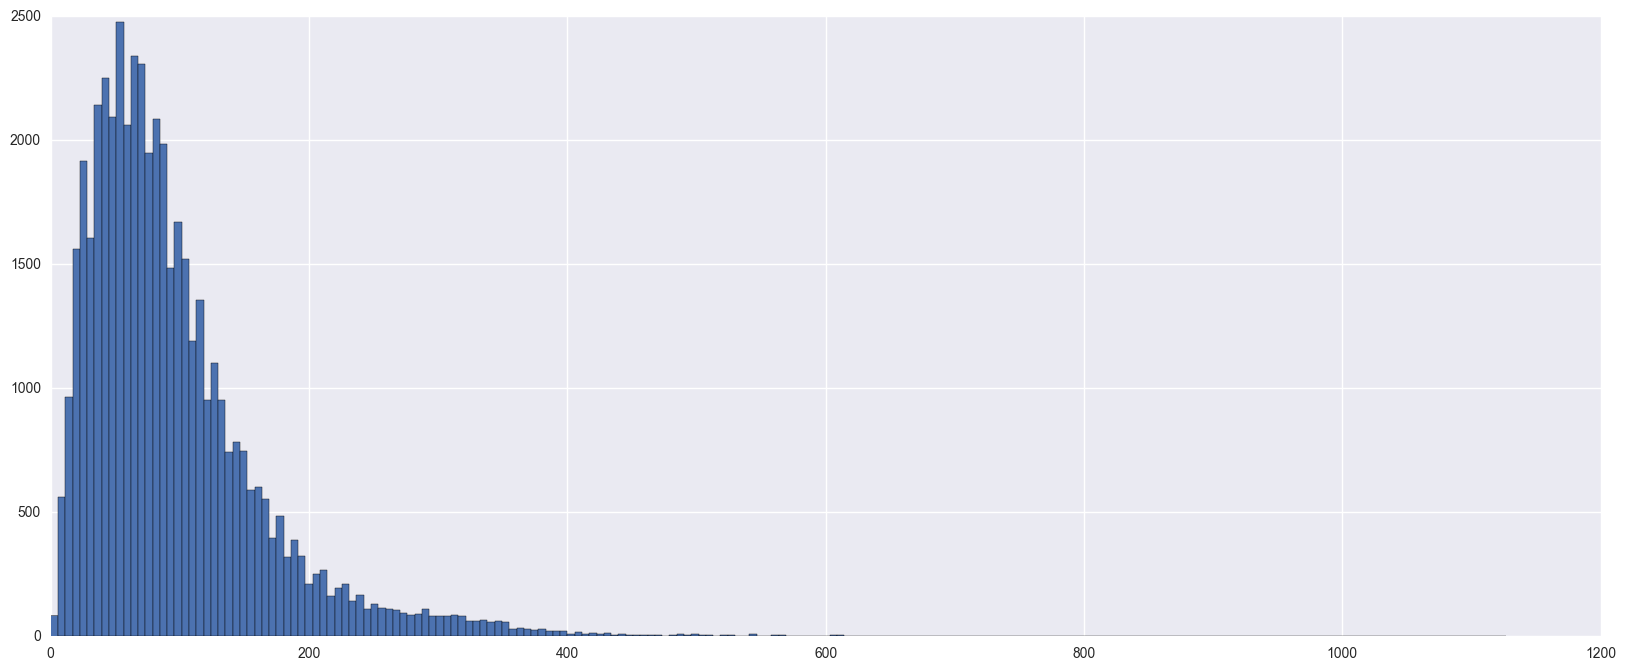

In [8]:
pd.Series(x_length).hist(bins = 200, figsize = [20,8])

In [43]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_train_y = encoder.transform(train_y)
encoded_test_y = encoder.transform(test_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_train_y = np_utils.to_categorical(encoded_train_y)
dummy_test_y = np_utils.to_categorical(encoded_test_y)

In [42]:
# truncate and pad input sequences
max_desc_length = 100
train_x = sequence.pad_sequences(train_x, maxlen=max_desc_length)
test_x = sequence.pad_sequences(test_x, maxlen=max_desc_length)

In [11]:
'''
mypath = '/Users/Lucy/Google Drive/MSDS/2016Fall/DSGA1006/Data/lstm-rnn'
f = open(mypath + '/crunchbase.train.10000.mercer.pickle','wb')
pickle.dump((train_x, dummy_train_y), f, -1)
f.close()
f = open(mypath + '/crunchbase.test.10000.mercer.pickle','wb')
pickle.dump((test_x, dummy_test_y), f, -1)
f.close()
'''

"\nmypath = '/Users/Lucy/Google Drive/MSDS/2016Fall/DSGA1006/Data/lstm-rnn'\nf = open(mypath + '/crunchbase.train.10000.mercer.pickle','wb')\npickle.dump((train_x, dummy_train_y), f, -1)\nf.close()\nf = open(mypath + '/crunchbase.test.10000.mercer.pickle','wb')\npickle.dump((test_x, dummy_test_y), f, -1)\nf.close()\n"

In [53]:
def lstm_model(embedding_vector_length = 256, max_desc_length = 100, top_words = 10000, y_dim = 543):
    # create model
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_desc_length))
    #model.add(LSTM(128,return_sequences=True,dropout_W=0.5, dropout_U=0.0))
    model.add(LSTM(128,dropout_W=0.5, dropout_U=0.0))
    model.add(Dense(y_dim, init='uniform', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [68]:
def mlp_model(x_dim = 100, y_dim = 543):
    model = Sequential()
    model.add(Dense(128, input_dim=x_dim, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_dim, init='uniform'))
    model.add(Activation('softmax'))

    #sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return model

In [56]:
def get_data(x, y, size = 500):
    if size > 0:
        # The test set is sorted by size, but we want to keep random
        # size example.  So we must select a random selection of the
        # examples.
        idx = np.arange(len(x))
        np.random.shuffle(idx)
        idx = idx[:size]
        train_x = [x[n] for n in idx]
        train_y = [y[n] for n in idx]
    
    else:
        train_x = x
        train_y = y
    
    return np.array(train_x), np.array(train_y)

In [57]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [60]:
model = mlp_model(x_dim = 100, y_dim = 543)

In [61]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 128)           12928       dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128)           0           dense_5[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 128)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 64)            8256        dropout_1[0][0]                  
___________________________________________________________________________________________

In [66]:
trunc_x, trunc_y = get_data(train_x, dummy_train_y, size = 0)
trunc_test_x, trunc_test_y = get_data(test_x, dummy_test_y, size = 0)

In [63]:
#results = cross_val_score(estimator, trunc_x, trunc_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## run model on all data for 5 epochs with 1 lstm layer of 32

In [ ]:
#training on all data with one lstm layer
model.fit(trunc_x, trunc_y, nb_epoch=100, batch_size=32,verbose = 1, validation_split = 0.1, shuffle = True)


Train on 43533 samples, validate on 4837 samples
Epoch 1/100
43533/43533 [==============================] - 15s - loss: 4.7500 - acc: 0.0662 - val_loss: 4.7575 - val_acc: 0.0604
Epoch 2/100
43533/43533 [==============================] - 16s - loss: 4.7544 - acc: 0.0661 - val_loss: 4.7631 - val_acc: 0.0604
Epoch 3/100
 4992/43533 [==>...........................] - ETA: 16s - loss: 4.7448 - acc: 0.0671

In [ ]:
scores = model.evaluate(trunc_test_x,trunc_test_y, verbose=1)
print scores

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(mypath + "model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
json_file.close()